#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Importing item.csv dataset

In [2]:
item = pd.read_csv('./amazon-items.csv')
item.head()

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.00,0.0
1,B0009N5L7K,Motorola,Motorola I265 phone,https://www.amazon.com/Motorola-i265-I265-phon...,https://m.media-amazon.com/images/I/419WBAVDAR...,3.0,https://www.amazon.com/product-reviews/B0009N5L7K,7,49.95,0.0
2,B000SKTZ0S,Motorola,MOTOROLA C168i AT&T CINGULAR PREPAID GOPHONE C...,https://www.amazon.com/MOTOROLA-C168i-CINGULAR...,https://m.media-amazon.com/images/I/71b+q3ydkI...,2.7,https://www.amazon.com/product-reviews/B000SKTZ0S,22,99.99,0.0
3,B001AO4OUC,Motorola,Motorola i335 Cell Phone Boost Mobile,https://www.amazon.com/Motorola-i335-Phone-Boo...,https://m.media-amazon.com/images/I/710UO8gdT+...,3.3,https://www.amazon.com/product-reviews/B001AO4OUC,21,0.00,0.0
4,B001DCJAJG,Motorola,Motorola V365 no contract cellular phone AT&T,https://www.amazon.com/Motorola-V365-contract-...,https://m.media-amazon.com/images/I/61LYNCVrrK...,3.1,https://www.amazon.com/product-reviews/B001DCJAJG,12,149.99,0.0


#### Importing reviews.csv dataset

In [3]:
review = pd.read_csv('./amazon-reviews.csv')
review.head()

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


#### Merging the two dataset

In [4]:
df = pd.merge(review, item, how="left", left_on="asin", right_on="asin")

In [5]:
df.rename(columns={"rating_x": "rating", "title_x": "title", "title_y": "item_title", "rating_y": "overall_rating"}, inplace=True)
df.head(100)

,asin,name,rating,date,verified,title,body,helpfulVotes,brand,item_title,url,image,overall_rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,B0029F2O3A,n. country boy,4,"October 6, 2010",False,never had a problem,never had a problem have had this phone for ov...,NaN,Samsung,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",https://www.amazon.com/Samsung-Alias2-Phone-Ve...,https://m.media-amazon.com/images/I/41HWHpfPlM...,3.0,https://www.amazon.com/product-reviews/B0029F2O3A,29,0.0,0.0
96,B0029F2O3A,Kyle Griswold,1,"October 29, 2009",False,Terrible,Has some real ram issues. It is really unusabl...,2.0,Samsung,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",https://www.amazon.com/Samsung-Alias2-Phone-Ve...,https://m.media-amazon.com/images/I/41HWHpfPlM...,3.0,https://www.amazon.com/product-reviews/B0029F2O3A,29,0.0,0.0
97,B0029F2O3A,Seth B. Tropinsky,5,"July 27, 2009",False,Wonderful innovative keypad,"Great phone, which has the comfort of a larger...",2.0,Samsung,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",https://www.amazon.com/Samsung-Alias2-Phone-Ve...,https://m.media-amazon.com/images/I/41HWHpfPlM...,3.0,https://www.amazon.com/product-reviews/B0029F2O3A,29,0.0,0.0
98,B0029F2O3A,A-la Dawn,5,"March 30, 2011",False,Best fone ever!!!,"I have had this fone for two years, and have n...",1.0,Samsung,"Samsung Alias2 U750 Phone, Black (Verizon Wire...",https://www.amazon.com/Samsung-Alias2-Phone-Ve...,https://m.media-amazon.com/images/I/41HWHpfPlM...,3.0,https://www.amazon.com/product-reviews/B0029F2O3A,29,0.0,0.0


In [6]:
print("The dataset contains {0[0]: .0f} rows and {0[1]: .0f} variables.".format(df.shape))
df.head()

The dataset contains  67986 rows and  17 variables.


,asin,name,rating,date,verified,title,body,helpfulVotes,brand,item_title,url,image,overall_rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0


#### Checking the null values

In [7]:
df.isnull().sum()

asin                  0
name                  2
rating                0
date                  0
verified              0
title                14
body                 21
helpfulVotes      40771
brand               200
item_title            0
url                   0
image                 0
overall_rating        0
reviewUrl             0
totalReviews          0
price                 0
originalPrice         0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

asin              0
name              0
rating            0
date              0
verified          0
title             0
body              0
helpfulVotes      0
brand             0
item_title        0
url               0
image             0
overall_rating    0
reviewUrl         0
totalReviews      0
price             0
originalPrice     0
dtype: int64

#### Removing all unnecessary columns

In [10]:
data = df.copy()
data = data[['asin', 'brand', 'rating', 'date', 'totalReviews', 'overall_rating', 'item_title', 'body']]
data.head(10)

,asin,brand,rating,date,totalReviews,overall_rating,item_title,body
43,B001AO4OUC,Motorola,4,"May 12, 2009",21,3.3,Motorola i335 Cell Phone Boost Mobile,This phone isn't kidding when it says military...
44,B001AO4OUC,Motorola,1,"November 19, 2012",21,3.3,Motorola i335 Cell Phone Boost Mobile,I bought this phone and found out IDEN phones ...
49,B001AO4OUC,Motorola,4,"November 25, 2012",21,3.3,Motorola i335 Cell Phone Boost Mobile,PHONE DID NOT COME WITH A SIM CARD....INFORMAT...
53,B001AO4OUC,Motorola,1,"October 18, 2009",21,3.3,Motorola i335 Cell Phone Boost Mobile,Wouldn't know anything about the cell phone I ...
54,B001AO4OUC,Motorola,4,"April 7, 2010",21,3.3,Motorola i335 Cell Phone Boost Mobile,For someone needing a very basic phone and ser...
55,B001AO4OUC,Motorola,1,"April 13, 2011",21,3.3,Motorola i335 Cell Phone Boost Mobile,I am a professional who recently purchased a S...
57,B001AO4OUC,Motorola,5,"August 13, 2009",21,3.3,Motorola i335 Cell Phone Boost Mobile,This phone is awesome. I have one through Boos...
59,B001AO4OUC,Motorola,1,"September 1, 2011",21,3.3,Motorola i335 Cell Phone Boost Mobile,I find texting impossible on this phone. As an...
60,B001AO4OUC,Motorola,1,"June 30, 2010",21,3.3,Motorola i335 Cell Phone Boost Mobile,I recently had an i776 which was ruined at wor...
61,B001AO4OUC,Motorola,5,"October 2, 2009",21,3.3,Motorola i335 Cell Phone Boost Mobile,I LOVE THIS PHONE! YES I WOULD LOVE IT TO HAVE...


#### Total Mobile count

<AxesSubplot:xlabel='brand', ylabel='count'>

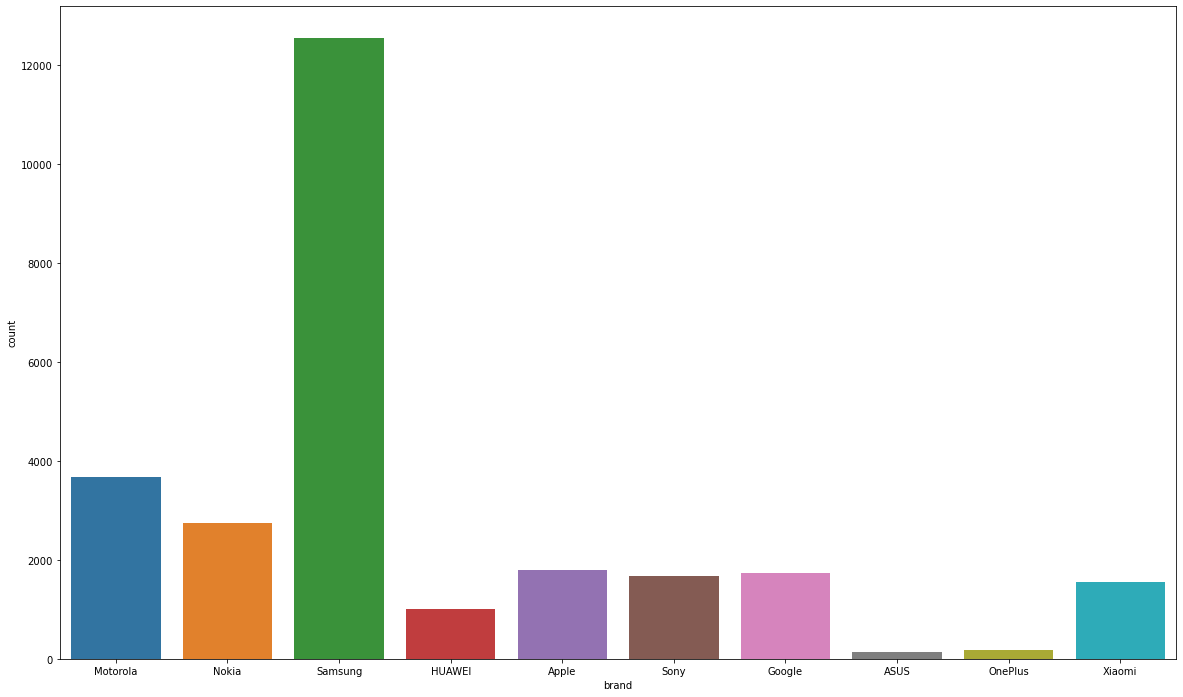

In [11]:
plt.figure(figsize=(20,12))
sns.countplot(x = 'brand', data =data)

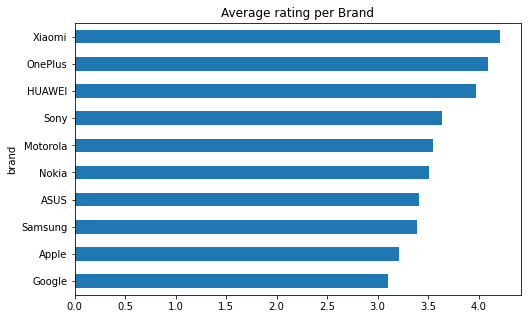

In [12]:
# Average rating per brand
ax = data.groupby("brand").mean()["rating"].sort_values().plot(kind="barh",
                                                                figsize=(8,5), 
                                                                title="Average rating per Brand")
plt.show()

#### Extracting year and month from date

In [13]:
# new data frame which has date and year
new = data["date"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
data["Dated"]= new[0] 
  
# making separate year column from new data frame 
data["year"]= new[1] 

data=data.drop(['date'], axis=1)
data.head()

,asin,brand,rating,totalReviews,overall_rating,item_title,body,Dated,year
43,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,This phone isn't kidding when it says military...,May 12,2009
44,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,I bought this phone and found out IDEN phones ...,November 19,2012
49,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,PHONE DID NOT COME WITH A SIM CARD....INFORMAT...,November 25,2012
53,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,Wouldn't know anything about the cell phone I ...,October 18,2009
54,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,For someone needing a very basic phone and ser...,April 7,2010


In [14]:
# Splitting the date 
new1 = data["Dated"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
data["month"]= new1[0] 
  
# adding day to the main dataset 
data["day"]= new1[1] 

data=data.drop(['Dated'], axis=1)
data.head()

,asin,brand,rating,totalReviews,overall_rating,item_title,body,year,month,day
43,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,This phone isn't kidding when it says military...,2009,May,12
44,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,I bought this phone and found out IDEN phones ...,2012,November,19
49,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,PHONE DID NOT COME WITH A SIM CARD....INFORMAT...,2012,November,25
53,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,Wouldn't know anything about the cell phone I ...,2009,October,18
54,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,For someone needing a very basic phone and ser...,2010,April,7


#### Ploting reviews over time

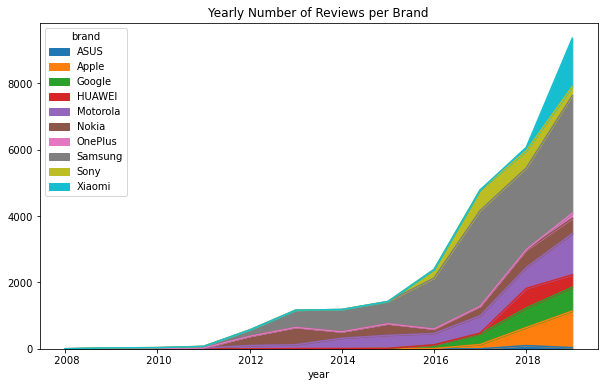

In [15]:

ax = pd.pivot_table(data, 
                    index="year", 
                    columns="brand", 
                    values="asin", 
                    aggfunc="count", 
                    fill_value=0).plot.area(title="Yearly Number of Reviews per Brand", figsize=(10, 6))

From this plot we can concluded that Samsung is the most rated brands, while Xiaomi has the highest average rating.

### Data  Preprocessing

In [16]:
def review_cleaning(text):
   
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [17]:
data['body']=data['body'].apply(lambda x:review_cleaning(x))
print(data['body'])

43       this phone isnt kidding when it says military ...
44       i bought this phone and found out iden phones ...
49       phone did not come with a sim cardinformation ...
53       wouldnt know anything about the cell phone i o...
54       for someone needing a very basic phone and ser...
                               ...                        
67978    update   stars now ive been using this phone a...
67979    update if you like sending and receiving pictu...
67980    i love my new phone ive been dying to do a rev...
67981    i love the camera on this phone the screen is ...
67982    ive been an xperia user for several years and ...
Name: body, Length: 27071, dtype: object


In [18]:
#Tokenization of text
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer=ToktokTokenizer()

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [19]:
#set stopwords to english
from nltk.corpus import stopwords

stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
#def remove_stopwords(text, is_lower_case=False):
#    tokens = tokenizer.tokenize(text)
#    tokens = [token.strip() for token in tokens]
#    if is_lower_case:
#        filtered_tokens = [token for token in tokens if token not in stopword_list]
#    else:
#        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
#    filtered_text = ' '.join(filtered_tokens)    
#    return filtered_text


#Apply function on review column
# data['body'] = data['body'].apply(remove_stopwords)
#print(data['body'])

{"that'll", 'has', 'most', 'off', 'after', 'how', 'over', 'they', 'whom', 'during', 'through', 'above', 'because', 'you', 'below', 'he', "couldn't", 'for', 'again', 'those', 'but', 'themselves', 'are', 'nor', 'it', "hadn't", "you'll", 'out', 'now', 'there', "aren't", 'when', 'this', 'own', 'having', 'had', 'will', 'where', 'don', 'of', 'is', 'only', 'yours', "hasn't", 're', 'couldn', 'myself', 'she', 'have', 'mightn', 'isn', 'weren', 'i', 'up', 'with', "she's", 'won', 'ain', 'd', 'very', 'other', 'these', 'doesn', "you've", 'just', 'or', 'some', 'me', 'such', "mightn't", 'am', 'hasn', 'was', "it's", 'll', 'mustn', 'shouldn', 'itself', "won't", 'who', 'all', 'him', 'in', 've', 'ours', "you're", 'being', 'further', 'why', 'didn', 'at', 'ourselves', 'while', 'my', 'no', 'then', 'yourself', 'if', 'yourselves', 'than', 'should', 'down', 'their', 'that', 'did', 'needn', "needn't", 'to', 'been', 'each', 'do', 'hers', 'haven', 'under', 'them', "mustn't", 'so', 'a', 'and', 'more', "wasn't", 'wo

In [20]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [21]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def preprocess_text(text):
  # Apply the tokenizer
  tokens = nltk.word_tokenize(text)

  # Remove stopwords
  stopwords = nltk.corpus.stopwords.words("english")
  tokens = [token for token in tokens if token not in stopwords]

  # Lemmatize and stem the tokens
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  preprocessed_tokens = []
  for token in tokens:
    lemma = lemmatizer.lemmatize(token)
    stem = stemmer.stem(lemma)
    preprocessed_tokens.append(stem)
    
    # Convert the list of tokens back into a string
  preprocessed_text = " ".join(preprocessed_tokens)

  # Return the full list of preprocessed tokens
  return preprocessed_text

# Preprocess the text
preprocessed_text = preprocess_text("This is some example text that I want to preprocess.")

# Print the preprocessed text
print(preprocessed_text)


thi exampl text i want preprocess .


In [22]:
preprocessed_text = preprocess_text("The camera quality is good, but the battery life of phone is not that nice!")
print(preprocessed_text)

the camera qualiti good , batteri life phone nice !


In [23]:
tokens = tokenizer.tokenize("The camera quality is good, but the battery life of phone is not that nice!")
filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
print(filtered_tokens)

['The', 'camera', 'quality', 'good', ',', 'battery', 'life', 'phone', 'nice', '!']


### Lemmatization and Stemming

### Sentiment Analysis

In [24]:
def f(row):
    
    if row['rating'] == 1.0 or row['rating'] == 2.0:
        val = 'Negative'
    elif row['rating'] == 3.0 or row['rating'] == 4.0 or row['rating'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [25]:

data['sentiment'] = data.apply(f, axis=1)
data.head(10)

,asin,brand,rating,totalReviews,overall_rating,item_title,body,year,month,day,sentiment
43,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,this phone isnt kidding when it says military ...,2009,May,12,Positive
44,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,i bought this phone and found out iden phones ...,2012,November,19,Negative
49,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,phone did not come with a sim cardinformation ...,2012,November,25,Positive
53,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,wouldnt know anything about the cell phone i o...,2009,October,18,Negative
54,B001AO4OUC,Motorola,4,21,3.3,Motorola i335 Cell Phone Boost Mobile,for someone needing a very basic phone and ser...,2010,April,7,Positive
55,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,i am a professional who recently purchased a s...,2011,April,13,Negative
57,B001AO4OUC,Motorola,5,21,3.3,Motorola i335 Cell Phone Boost Mobile,this phone is awesome i have one through boost...,2009,August,13,Positive
59,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,i find texting impossible on this phone as ano...,2011,September,1,Negative
60,B001AO4OUC,Motorola,1,21,3.3,Motorola i335 Cell Phone Boost Mobile,i recently had an which was ruined at work i ...,2010,June,30,Negative
61,B001AO4OUC,Motorola,5,21,3.3,Motorola i335 Cell Phone Boost Mobile,i love this phone yes i would love it to have ...,2009,October,2,Positive


In [26]:

dataset = data[['brand','body', 'rating', 'sentiment']]
dataset.columns = ['Brand','Review', 'Rating', 'Sentiment']

dataset.head()

,Brand,Review,Rating,Sentiment
43,Motorola,this phone isnt kidding when it says military ...,4,Positive
44,Motorola,i bought this phone and found out iden phones ...,1,Negative
49,Motorola,phone did not come with a sim cardinformation ...,4,Positive
53,Motorola,wouldnt know anything about the cell phone i o...,1,Negative
54,Motorola,for someone needing a very basic phone and ser...,4,Positive


In [27]:
dataset['Review'] = dataset['Review'].apply(preprocess_text)
dataset.head()

C:\Users\user\AppData\Local\Temp\ipykernel_6184\3292282561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Review'] = dataset['Review'].apply(preprocess_text)


,Brand,Review,Rating,Sentiment
43,Motorola,phone isnt kid say militari spec hole pocket w...,4,Positive
44,Motorola,bought phone found iden phone sim card longer ...,1,Negative
49,Motorola,phone come sim cardinform wouldv like phone wo...,4,Positive
53,Motorola,wouldnt know anyth cell phone order person has...,1,Negative
54,Motorola,someon need basic phone servic ie email access...,4,Positive


In [28]:
data['sentiment'].value_counts()

Positive    18172
Negative     8899
Name: sentiment, dtype: int64

In [29]:
lb=LabelEncoder()
dataset['Sentiment'] = lb.fit_transform(dataset['Sentiment'])
dataset.head()

C:\Users\user\AppData\Local\Temp\ipykernel_6184\2917107749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Sentiment'] = lb.fit_transform(dataset['Sentiment'])


,Brand,Review,Rating,Sentiment
43,Motorola,phone isnt kid say militari spec hole pocket w...,4,1
44,Motorola,bought phone found iden phone sim card longer ...,1,0
49,Motorola,phone come sim cardinform wouldv like phone wo...,4,1
53,Motorola,wouldnt know anyth cell phone order person has...,1,0
54,Motorola,someon need basic phone servic ie email access...,4,1


### Bags of words model

It is used to convert text documents to numerical vectors or bag of words.

In [30]:
#Count vectorizer for bag of words
cv=CountVectorizer()
# max_features=10000,binary=False,ngram_range=(1,3)

setences = dataset['Review']

# Fit the vectorizer on the text documents
bow = cv.fit_transform(setences)

vocab = cv.vocabulary_
    
bow_array = bow.toarray()

print(bow_array)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Term Frequency-Inverse Document Frequency model (TFIDF)

It is used to convert text documents to matrix of tfidf features.

In [36]:
from itertools import chain
documents = dataset['Review']

# Create the tf-idf vectorizer
tv = TfidfVectorizer()

# Fit the vectorizer on the documents
tfidf_matrix = tv.fit_transform(documents)

# View the tf-idf matrix



In [37]:
    x = dataset['Review']
    y = dataset['Sentiment']
    
    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = dataset.Sentiment, random_state = 42)
    
    print(x_train.shape,y_train.shape)
    print(x_test.shape,y_test.shape)
    

(21656,) (21656,)
(5415,) (5415,)


### Machine Learning Classification

#### Logistic regression model for both bag of words and tfidf features

In [38]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#### Logiststic Regression Classifier

In [39]:
classifier1 = LogisticRegression()

In [40]:
pipeline1t = Pipeline([('tfidf', tv), ('clf', classifier1) ])

In [41]:
pipeline1t.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [42]:
y_pred = pipeline1t.predict(x_test)

In [43]:
confusion_matrix(y_test, y_pred)

array([[1407,  373],
       [ 280, 3355]], dtype=int64)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1780
           1       0.90      0.92      0.91      3635

    accuracy                           0.88      5415
   macro avg       0.87      0.86      0.86      5415
weighted avg       0.88      0.88      0.88      5415



In [45]:
print("lr_tfidf_score :{:.2f}%".format(accuracy_score(y_test, y_pred)*100))

lr_tfidf_score :87.94%


In [46]:
pipeline1b = Pipeline([('bow', cv), ('clf', classifier1) ])

In [47]:
pipeline1b.fit(x_train, y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('bow', CountVectorizer()), ('clf', LogisticRegression())])

In [48]:
y_pred = pipeline1b.predict(x_test)

In [49]:
confusion_matrix(y_test, y_pred)

array([[1394,  386],
       [ 327, 3308]], dtype=int64)

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Confusion matrix values
# confusion_matrix = [[10, 5], [2, 8]]

# # Labels for the rows and columns
# labels = ['Positive', 'Negative']

# # Create the heatmap
# sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

# # Add labels to the x and y axes
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')

# # Show the plot
# plt.show()

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1780
           1       0.90      0.91      0.90      3635

    accuracy                           0.87      5415
   macro avg       0.85      0.85      0.85      5415
weighted avg       0.87      0.87      0.87      5415



In [51]:
# round(accuracy_score(y_test, y_pred)*100,2)
print("lr_bow_score :{:.2f}%".format(accuracy_score(y_test, y_pred)*100))

lr_bow_score :86.83%


#### Support Vector Classifier

In [52]:
classifier2 = LinearSVC()

In [53]:
pipeline2t = Pipeline([('tfidf', tv), ('clf', classifier2) ])

In [54]:
pipeline2t.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [55]:
y_pred = pipeline2t.predict(x_test)

In [57]:
confusion_matrix(y_test, y_pred)

array([[1426,  354],
       [ 325, 3310]], dtype=int64)

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Confusion matrix values
# confusion_matrix = [[10, 5], [2, 8]]

# # Labels for the rows and columns
# labels = ['Positive', 'Negative']

# # Create the heatmap
# sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

# # Add labels to the x and y axes
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')

# # Show the plot
# plt.show()

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1780
           1       0.90      0.91      0.91      3635

    accuracy                           0.87      5415
   macro avg       0.86      0.86      0.86      5415
weighted avg       0.87      0.87      0.87      5415



In [58]:
round(accuracy_score(y_test, y_pred)*100,2)
print("svc_tfidf_score :{:.2f}%".format(accuracy_score(y_test, y_pred)*100))

svc_tfidf_score :87.46%


In [59]:
pipeline2b = Pipeline([('bow', cv), ('clf', classifier2) ])

In [60]:
pipeline2b.fit(x_train, y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('bow', CountVectorizer()), ('clf', LinearSVC())])

In [61]:
y_pred = pipeline2b.predict(x_test)

In [62]:
confusion_matrix(y_test, y_pred)

array([[1378,  402],
       [ 354, 3281]], dtype=int64)

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1780
           1       0.89      0.90      0.90      3635

    accuracy                           0.86      5415
   macro avg       0.84      0.84      0.84      5415
weighted avg       0.86      0.86      0.86      5415



In [64]:
round(accuracy_score(y_test, y_pred)*100,2)
print("svc_bow_score :{:.2f}%".format(accuracy_score(y_test, y_pred)*100))

svc_bow_score :86.04%


In [65]:
import joblib
joblib.dump(pipeline2t, 'SentimentAnalysis_Model_Pipeline.pkl')

['SentimentAnalysis_Model_Pipeline.pkl']

In [66]:
prediction = pipeline2t.predict(["Samsung Phone has good camera quality"])

if prediction == 1:
  print("Result: This review is positive")
else:
  print("Result: This review is negative")

Result: This review is positive


In [67]:
new_review = []
pred_sentiment = []

while True:

  #ask for a new review of phone purchased from Amazon
  review = input("Please type the phone review - ")

  if review == 'skip':
    print("See you soon!")
    break

  else:
    prediction = pipeline2t.predict([review])

    if prediction == 1:
      result = 'Positive'
      print("Result: This review is positive\n")
    else:
      result = 'Negative'
      print("Result: This review is negative\n")

  new_review.append(review)
  pred_sentiment.append(result)

Please type the phone review - Great features
Result: This review is positive

Please type the phone review - Good display screen
Result: This review is positive

Please type the phone review - poor battery life
Result: This review is negative

Please type the phone review - slow charging battery
Result: This review is positive

Please type the phone review - bad sound quality
Result: This review is negative

Please type the phone review - camera quality is best
Result: This review is positive

Please type the phone review - skip
See you soon!


In [68]:
Results_Summary = pd.DataFrame(
    {'New Review': new_review,
      'Sentiment': pred_sentiment, 
    })

Results_Summary.to_csv("./c2_Predict_Sentiments.tsv", sep='\t', encoding='UTF-8', index=False)
Results_Summary

,New Review,Sentiment
0,Great features,Positive
1,Good display screen,Positive
2,poor battery life,Negative
3,slow charging battery,Positive
4,bad sound quality,Negative
5,camera quality is best,Positive


In [69]:
from joblib import dump, load
# Save the prediction dataframe to a CSV file using joblib
joblib.dump(Results_Summary, "Results_Summary.csv")


['Results_Summary.csv']

## Sentimental Analysis using Vader

There are two common approaches for text sentiment analysis: the lexical method and the machine learning methhod.

The lexcial method maps the new text to a pre-defined "dictionary of sentiment". VADER is one example of such method. Wtihe VADER, the sentiment score of a sentence is the normalised sum of sentiment scores of each word in that sentence.

In [70]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [71]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [72]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(df['body'].iloc[11])

{'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'compound': 0.2263}

In [73]:
dfs = df.copy()
dfs = dfs[['brand', 'rating','overall_rating','title','body']]
dfs.head()

,brand,rating,overall_rating,title,body
43,Motorola,4,3.3,tough little phone,This phone isn't kidding when it says military...
44,Motorola,1,3.3,Boost Mobile no Longer allows IDEN service,I bought this phone and found out IDEN phones ...
49,Motorola,4,3.3,SIM CARD,PHONE DID NOT COME WITH A SIM CARD....INFORMAT...
53,Motorola,1,3.3,Cell,Wouldn't know anything about the cell phone I ...
54,Motorola,4,3.3,For a basic phone quite good,For someone needing a very basic phone and ser...


In [74]:
def review_cleaning(text):

    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [75]:
dfs['body']=dfs['body'].apply(lambda x:review_cleaning(x))
dfs['title']=dfs['title'].apply(lambda x:review_cleaning(x))
dfs.head()

,brand,rating,overall_rating,title,body
43,Motorola,4,3.3,tough little phone,this phone isnt kidding when it says military ...
44,Motorola,1,3.3,boost mobile no longer allows iden service,i bought this phone and found out iden phones ...
49,Motorola,4,3.3,sim card,phone did not come with a sim cardinformation ...
53,Motorola,1,3.3,cell,wouldnt know anything about the cell phone i o...
54,Motorola,4,3.3,for a basic phone quite good,for someone needing a very basic phone and ser...


In [76]:
dfs['title_score'] = dfs['title'].apply(lambda x: sid.polarity_scores(x))
dfs.head()

,brand,rating,overall_rating,title,body,title_score
43,Motorola,4,3.3,tough little phone,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp..."
44,Motorola,1,3.3,boost mobile no longer allows iden service,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co..."
49,Motorola,4,3.3,sim card,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
53,Motorola,1,3.3,cell,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
54,Motorola,4,3.3,for a basic phone quite good,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp..."


In [77]:
dfs['title_compound'] = dfs['title_score'].apply(lambda x: x['compound'])
dfs.head()

,brand,rating,overall_rating,title,body,title_score,title_compound
43,Motorola,4,3.3,tough little phone,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",-0.1280
44,Motorola,1,3.3,boost mobile no longer allows iden service,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co...",0.1280
49,Motorola,4,3.3,sim card,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
53,Motorola,1,3.3,cell,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
54,Motorola,4,3.3,for a basic phone quite good,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.4927


In [78]:
  def f(dfs):
        
    if dfs['title_compound'] >= 0.05 :
       value = "Positive"
 
    elif dfs['title_compound'] <= - 0.05 :
      value = "Negative"
 
    else :
       value = "Neutral"
    
    return value

dfs['title_sentiment'] = dfs.apply(f, axis=1)
dfs.head()


,brand,rating,overall_rating,title,body,title_score,title_compound,title_sentiment
43,Motorola,4,3.3,tough little phone,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",-0.1280,Negative
44,Motorola,1,3.3,boost mobile no longer allows iden service,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co...",0.1280,Positive
49,Motorola,4,3.3,sim card,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
53,Motorola,1,3.3,cell,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
54,Motorola,4,3.3,for a basic phone quite good,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.4927,Positive


In [79]:
dfs['title_sentiment'].value_counts()

Positive    12605
Neutral      9876
Negative     4590
Name: title_sentiment, dtype: int64

In [80]:
dfs['body_score'] = dfs['body'].apply(lambda x: sid.polarity_scores(x))
dfs.head()

,brand,rating,overall_rating,title,body,title_score,title_compound,title_sentiment,body_score
43,Motorola,4,3.3,tough little phone,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",-0.1280,Negative,"{'neg': 0.077, 'neu': 0.865, 'pos': 0.057, 'co..."
44,Motorola,1,3.3,boost mobile no longer allows iden service,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co...",0.1280,Positive,"{'neg': 0.058, 'neu': 0.871, 'pos': 0.071, 'co..."
49,Motorola,4,3.3,sim card,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.139, 'neu': 0.723, 'pos': 0.138, 'co..."
53,Motorola,1,3.3,cell,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.059, 'neu': 0.896, 'pos': 0.045, 'co..."
54,Motorola,4,3.3,for a basic phone quite good,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.4927,Positive,"{'neg': 0.074, 'neu': 0.841, 'pos': 0.085, 'co..."


In [81]:
dfs['body_compound'] = dfs['body_score'].apply(lambda x: x['compound'])
dfs.head()

,brand,rating,overall_rating,title,body,title_score,title_compound,title_sentiment,body_score,body_compound
43,Motorola,4,3.3,tough little phone,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",-0.1280,Negative,"{'neg': 0.077, 'neu': 0.865, 'pos': 0.057, 'co...",-0.7557
44,Motorola,1,3.3,boost mobile no longer allows iden service,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co...",0.1280,Positive,"{'neg': 0.058, 'neu': 0.871, 'pos': 0.071, 'co...",0.1280
49,Motorola,4,3.3,sim card,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.139, 'neu': 0.723, 'pos': 0.138, 'co...",-0.2708
53,Motorola,1,3.3,cell,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.059, 'neu': 0.896, 'pos': 0.045, 'co...",-0.1426
54,Motorola,4,3.3,for a basic phone quite good,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.4927,Positive,"{'neg': 0.074, 'neu': 0.841, 'pos': 0.085, 'co...",0.5940


In [82]:
  def f(dfs):
        
    if dfs['body_compound'] >= 0.05 :
       value = "Positive"
 
    elif dfs['body_compound'] <= - 0.05 :
      value = "Negative"
 
    else :
       value = "Neutral"
    
    return value
 

In [83]:
dfs['body_sentiment'] = dfs.apply(f, axis=1)
dfs.head()

,brand,rating,overall_rating,title,body,title_score,title_compound,title_sentiment,body_score,body_compound,body_sentiment
43,Motorola,4,3.3,tough little phone,this phone isnt kidding when it says military ...,"{'neg': 0.429, 'neu': 0.571, 'pos': 0.0, 'comp...",-0.1280,Negative,"{'neg': 0.077, 'neu': 0.865, 'pos': 0.057, 'co...",-0.7557,Negative
44,Motorola,1,3.3,boost mobile no longer allows iden service,i bought this phone and found out iden phones ...,"{'neg': 0.222, 'neu': 0.505, 'pos': 0.273, 'co...",0.1280,Positive,"{'neg': 0.058, 'neu': 0.871, 'pos': 0.071, 'co...",0.1280,Positive
49,Motorola,4,3.3,sim card,phone did not come with a sim cardinformation ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.139, 'neu': 0.723, 'pos': 0.138, 'co...",-0.2708,Negative
53,Motorola,1,3.3,cell,wouldnt know anything about the cell phone i o...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,"{'neg': 0.059, 'neu': 0.896, 'pos': 0.045, 'co...",-0.1426,Negative
54,Motorola,4,3.3,for a basic phone quite good,for someone needing a very basic phone and ser...,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.4927,Positive,"{'neg': 0.074, 'neu': 0.841, 'pos': 0.085, 'co...",0.5940,Positive


In [84]:
dfs['body_sentiment'].value_counts()

Positive    18047
Negative     6469
Neutral      2555
Name: body_sentiment, dtype: int64

Text(0.5, 1.0, 'Comments sentiment analysis')

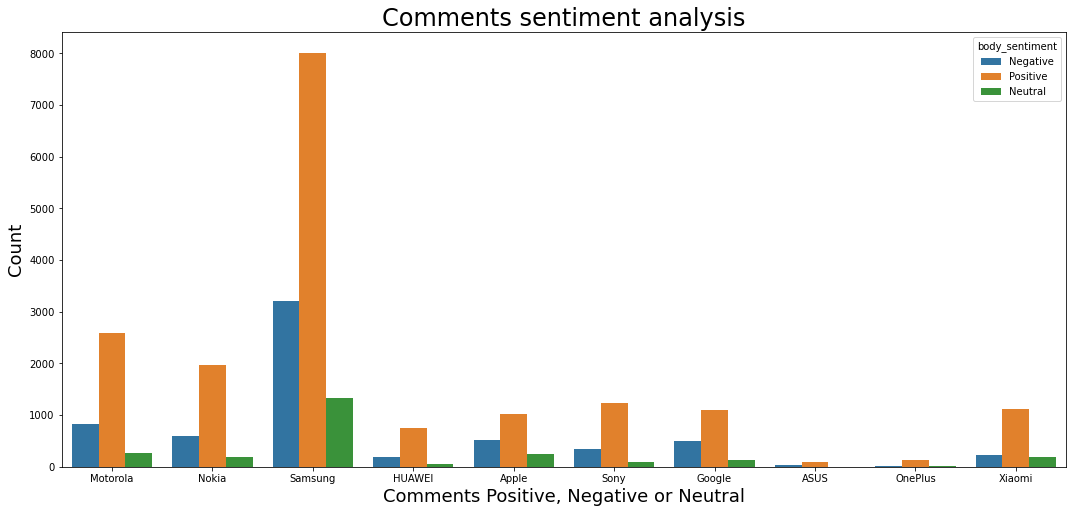

In [85]:
plt.figure(figsize=(18,8))
sns.countplot(x = 'brand', hue = 'body_sentiment', data = dfs)
plt.xlabel('Comments Positive, Negative or Neutral', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.title('Comments sentiment analysis', fontsize = 24)

Text(0.5, 1.0, 'Title sentiment analysis')

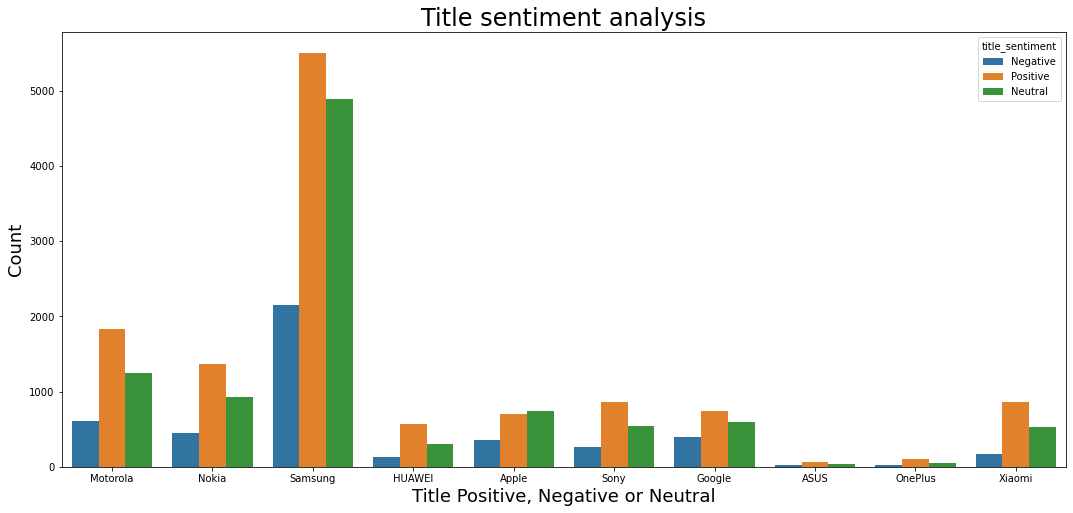

In [86]:
plt.figure(figsize=(18,8))
sns.countplot(x = 'brand', hue = 'title_sentiment', data = dfs)
plt.xlabel('Title Positive, Negative or Neutral', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.title('Title sentiment analysis', fontsize = 24)

In [87]:
print(classification_report(dfs['title_sentiment'], dfs['body_sentiment']))

              precision    recall  f1-score   support

    Negative       0.40      0.56      0.47      4590
     Neutral       0.72      0.19      0.29      9876
    Positive       0.61      0.87      0.72     12605

    accuracy                           0.57     27071
   macro avg       0.57      0.54      0.49     27071
weighted avg       0.61      0.57      0.52     27071



#### Conclusion for sentiment analysis using vader

As a result, we can conclude that the majority of the reviews and titles are positive, and the correlation between the rating and the sentiment of the reviews is also favorable.

## Word Cloud

In [88]:
reviews = df.copy()

In [89]:
reviews["positivity"] = reviews["rating"].apply(lambda x: 1 if x>3 else(0 if x==3 else -1))

In [90]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
keywords = reviews["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
lemma = WordNetLemmatizer()
def clean_text(text):
    
    text = text.lower()
    
    wordList = text.split()
    
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
   
    wordList = [word for word in wordList if word not in stop]
   
    wordList = [word for word in wordList if word not in keywords]
    
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)


In [91]:
reviews["body"] = reviews["body"].astype("str")
reviews["clean_text"] = reviews["body"].apply(clean_text)

##### Creating wordcloud

In [92]:
def word_freq_dict(text):
  
    wordList = text.split()
  
    wordFreqDict = {word: wordList.count(word) for word in wordList}
    
    return wordFreqDict


##### Brand subsets

In [93]:

apple = reviews[reviews["brand"]=="Apple"].sort_values(by=["date"], ascending=False)
samsung = reviews[reviews["brand"]=="Samsung"].sort_values(by=["date"], ascending=False)


In [94]:
from wordcloud import WordCloud, ImageColorGenerator

# Function to create a wordcloud from dictionary of word frequency
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(10, 6)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [95]:
# Function to plot top10 positive words and top10 negative words in a grouped bar plot (from dictionaries)

def topn_wordfreq_bar_both(pos_word_freq_dict, neg_word_freq_dict, pos_num_doc, neg_num_doc, topn, title, palette, height=6, aspect=2):
    # Transforming positive word frequency into DF
    df_pos = pd.DataFrame.from_dict(pos_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_pos.columns = ["frequency"]
    df_pos["frequency"] = df_pos["frequency"] / pos_num_doc
    df_pos["label"] = "Positive"
    
    # Transforming negative word frequency into DF
    df_neg = pd.DataFrame.from_dict(neg_word_freq_dict, orient="index").sort_values(by=0, ascending=False).head(topn)
    df_neg.columns = ["frequency"]
    df_neg["frequency"] = df_neg["frequency"] / neg_num_doc
    df_neg["label"] = "Negative"
    
    # Append two dataframes
    df_append = df_pos.append(df_neg)
    df_append.reset_index(inplace=True)
    # Plot
    sns.catplot(x="index", y="frequency", hue="label", data=df_append, 
                kind="bar",
                palette=palette,
                height=height, aspect=aspect, 
                legend_out=False)
    plt.title(title)
    plt.show()

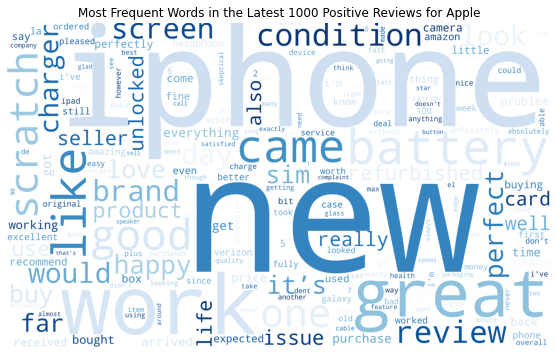

In [96]:
# Wordclouds for 1000 reviews for Apple

apple_pos = " ".join(apple[apple["positivity"]==1]["clean_text"][0:1000])
apple_pos_word_freq = word_freq_dict(apple_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(apple_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Apple")

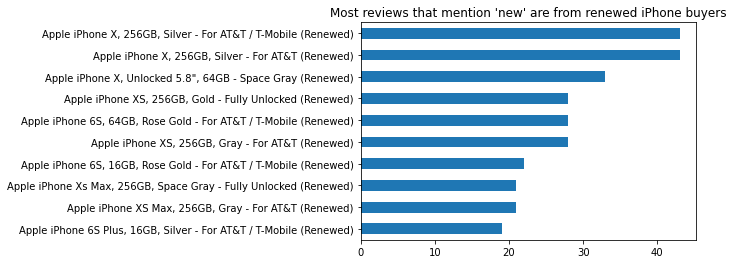

In [97]:
apple[apple["clean_text"].apply(lambda x: "new" in x)]["item_title"].value_counts().sort_values(ascending=True).tail(10).plot(kind="barh")
plt.title("Most reviews that mention 'new' are from renewed iPhone buyers")
plt.show()

In [98]:
apple["renewed"] = apple["item_title"].apply(lambda x: ("Renewed" in x) | ("Reburshied" in x))
print("{0: 0.1%} iPhones that were sold on Amazon are renewed/reburshied.".format(apple["renewed"].sum() / len(apple["renewed"])))

 99.9% iPhones that were sold on Amazon are renewed/reburshied.


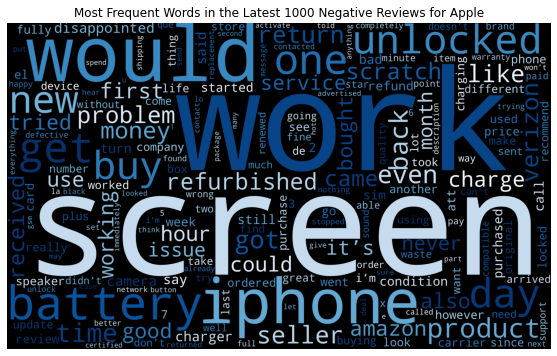

In [99]:
apple_neg = " ".join(apple[apple["positivity"]==-1]["clean_text"][0:1000])
apple_neg_word_freq = word_freq_dict(apple_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="black")
wordcloud_from_frequency(apple_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Apple")

C:\Users\user\AppData\Local\Temp\ipykernel_6184\515505373.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df_pos.append(df_neg)


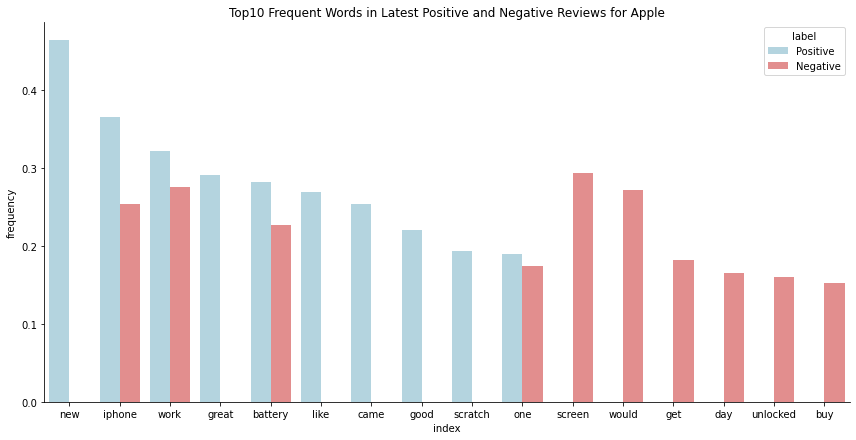

In [100]:
topn_wordfreq_bar_both(apple_pos_word_freq, apple_neg_word_freq, 
                       min(sum(apple["positivity"]==1), 1000), 
                       min(sum(apple["positivity"]==-1), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews for Apple", 
                       ["lightblue", "lightcoral"], 
                       height=6, aspect=2)

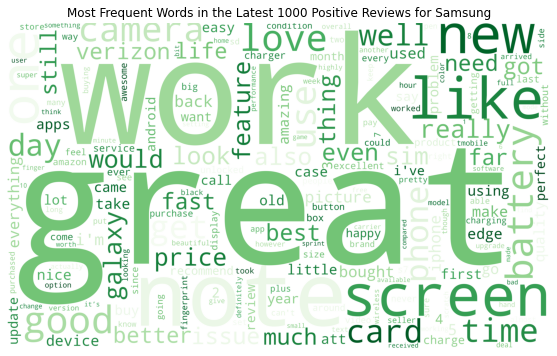

In [101]:
# Wordclouds for 1000 reviews for Samsung

samsung_pos = " ".join(samsung[samsung["positivity"]==1]["clean_text"][0:1000])
samsung_pos_word_freq = word_freq_dict(samsung_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Greens",
                      background_color="white")
wordcloud_from_frequency(samsung_pos_word_freq, "Most Frequent Words in the Latest 1000 Positive Reviews for Samsung")

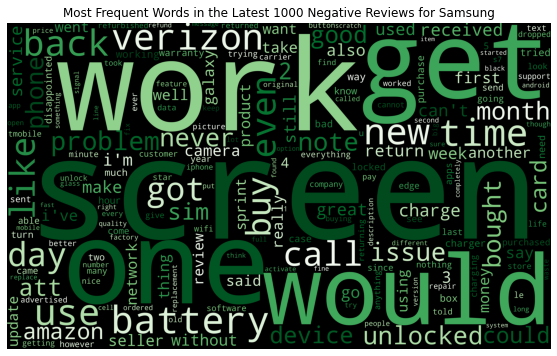

In [102]:
samsung_neg = " ".join(samsung[samsung["positivity"]==-1]["clean_text"][0:1000])
samsung_neg_word_freq = word_freq_dict(samsung_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Greens",
                      background_color="black")
wordcloud_from_frequency(samsung_neg_word_freq, "Most Frequent Words in the Latest 1000 Negative Reviews for Samsung")


C:\Users\user\AppData\Local\Temp\ipykernel_6184\515505373.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_append = df_pos.append(df_neg)


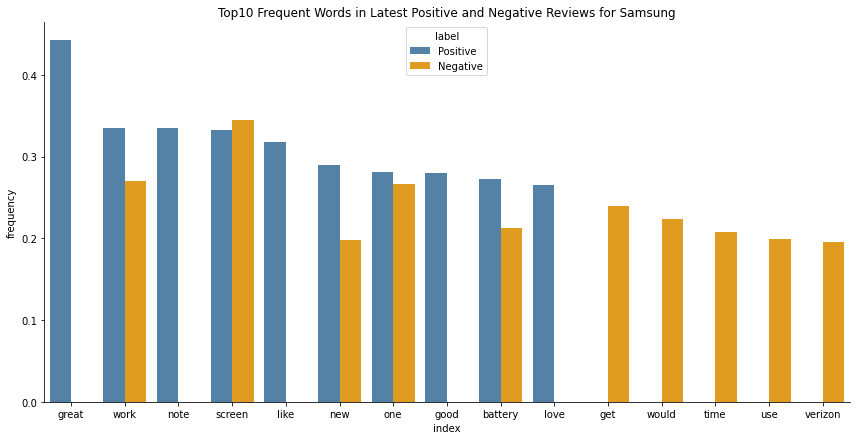

In [103]:
topn_wordfreq_bar_both(samsung_pos_word_freq, samsung_neg_word_freq, 
                       min(sum(samsung["positivity"]==1), 1000), 
                       min(sum(samsung["positivity"]==-1), 1000), 
                       10, 
                       "Top10 Frequent Words in Latest Positive and Negative Reviews for Samsung", 
                       ["steelblue", "orange"], 
                       height=6, aspect=2)

The visulisations above show that:

The most important considerations for cell phone buyers are battery health and screen condition.

The majority of iPhones sold on Amazon are renewed/refurbished. Apple customers are satisfied if their purchases are in (near)    new condition, and they usually complain if there is a scratch on the screen or the battery health is poor.

Samsung buyers are generally satisfied with the overall performance of their purchases, but they have complained about the        screen. Some customers also complained about unlocked phones sold by carriers.